<a href="https://colab.research.google.com/github/pabanib/CEFIM-Informes/blob/main/Acciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de acciones



In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

In [3]:
Acciones = ['ABNB','GOOGL','IBM','INTC','TSLA','MELI','MSFT', 'AMD','NVDA','DIA','AAPL','GOLD','PYPL','KO','AAL','TUP']

In [4]:
acciones = {}
errores = []
for i in Acciones:
    try:
      p = yf.Ticker(i).history(start = '2016-01-01')
      acciones[i] = p
    except TypeError:
      errores.append(i)
acciones = pd.concat(acciones)

In [5]:
acciones.loc['NVDA']

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2016-01-04 00:00:00-05:00,0.787906,0.794982,0.781806,0.789858,358076000,0.0,0.0,NaN
2016-01-05 00:00:00-05:00,0.804743,0.815967,0.793030,0.802547,490272000,0.0,0.0,NaN
2016-01-06 00:00:00-05:00,0.789370,0.793030,0.760333,0.769362,449344000,0.0,0.0,NaN
2016-01-07 00:00:00-05:00,0.750084,0.755209,0.729100,0.738860,645304000,0.0,0.0,NaN
2016-01-08 00:00:00-05:00,0.748376,0.749108,0.721535,0.723000,398472000,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...
2024-09-18 00:00:00-04:00,115.889999,117.699997,113.220001,113.370003,310318900,0.0,0.0,NaN
2024-09-19 00:00:00-04:00,117.349998,119.660004,117.250000,117.870003,293506400,0.0,0.0,NaN
2024-09-20 00:00:00-04:00,117.059998,118.620003,115.389999,116.000000,382462400,0.0,0.0,NaN


In [6]:
fech = '2020-01-01'
pap = 'intc'
pap = pap.upper()

val = pap


df = acciones.loc[val].loc[fech:]
df['mm'] = acciones.loc[val].loc[fech:].Close.rolling(30).mean()

fig = px.line(df, y = ['Close','mm'])

fig.show()

In [7]:
acci = acciones.Close.unstack(0).rolling(30).mean()
acci = acci/acci.loc['2024-01-03']
px.line(acci.loc['2016-01-01':])

In [8]:
(acci.iloc[-1]-1).sort_values()

,2024-09-24 00:00:00-04:00
INTC,-0.542942
AAL,-0.212934
ABNB,-0.130220
TSLA,-0.093576
AMD,0.129358
MSFT,0.129595
DIA,0.137872
AAPL,0.168107
GOLD,0.171659
GOOGL,0.180570


## Portafolio

Para trabajar un poortafolio de acciones creamos una clase llamada portafolio que realiza todas las acciones necesarias para los movimientos.

In [109]:
class portafolio():
  def __init__(self, plata = 0):
    self.plata = plata
    self.acciones = {}
    self.movimientos = pd.DataFrame()
    self.num_mov = 0
    self.mov_plata = pd.DataFrame()
    self.num_mov_plata = 0

  def ing_dinero(self, monto, fecha):
    self.plata += monto
    print(f'Ingreso {monto} dólares')
    self.num_mov_plata += 1
    self.mov_plata = pd.concat([self.mov_plata, pd.DataFrame({'fecha': fecha, 'monto': monto}, index = [self.num_mov_plata])])


  def ret_dinero(self, monto, fecha):
    if monto > self.plata:
      print('No tienes suficiente dinero')
    else:
      self.plata -= monto
      print(f'Retiro {monto} dólares')
      self.num_mov_plata += 1
      self.mov_plata = pd.concat([self.mov_plata, pd.DataFrame({'fecha': fecha, 'monto': monto*-1}, index = [self.num_mov_plata])])

  def comprar_accion(self, ticker, cantidad, fecha ):
    precio = acciones.loc[ticker].loc[fecha].Open
    monto = cantidad * precio
    if monto > self.plata:
      print('No tienes suficiente dinero')
    else:
      self.plata -= monto
      if ticker in self.acciones.keys():
        self.acciones[ticker] += cantidad
      else:
        self.acciones[ticker] = cantidad
      self.mov_historicos(ticker, cantidad, fecha)


  def vender_accion(self, ticker, cantidad, fecha):
    precio = acciones.loc[ticker].loc[fecha].Open
    monto = cantidad * precio
    self.plata += monto
    self.acciones[ticker] -= cantidad
    self.mov_historicos(ticker, cantidad*-1, fecha)
    if self.acciones[ticker] == 0:
      del self.acciones[ticker]

  def mov_historicos(self, ticker, cantidad, fecha):
    precio = acciones.loc[ticker].loc[fecha].Open
    monto = cantidad * precio
    dic = {'ticker': ticker, 'cantidad': cantidad, 'fecha': fecha, 'precio': precio, 'monto': monto}
    self.num_mov += 1
    self.movimientos = pd.concat([self.movimientos, pd.DataFrame(dic, index = [self.num_mov])])

  def balance(self, fecha):
    df = self.movimientos.groupby('ticker').agg({'cantidad': 'sum','precio': 'mean' ,'monto': 'sum'})

    for k in self.acciones.keys():
      precio_actual = acciones.loc[k].iloc[-1].Close
      df.loc[k, 'Precio Actual'] = precio_actual
      df.loc[k, 'Valor Actual'] = df.loc[k, 'cantidad'] * precio_actual
      df.loc[k, 'Rendimiento'] = np.round((df.loc[k, 'Precio Actual'] - df.loc[k, 'precio']) / df.loc[k, 'precio']*100,2)
      df.loc[k, 'Ganancia'] = np.round(df.loc[k, 'Valor Actual'] - df.loc[k, 'monto'],2)

    self.posiciones = df
    return df


Abrimos un portafolio y le ingresamos dinero. Luego se procede a realizar las primeras compras de acciones

In [112]:
porta = portafolio()
porta.ing_dinero(120000, '2021-05-02')
porta.comprar_accion('PYPL', 80,'2021-05-14')
porta.comprar_accion('GOOGL', 350,'2021-03-10')
porta.comprar_accion('AAL', 150,'2022-01-25')



Ingreso 120000 dólares


Podemos consultar los movimientos que fuimos realizando, el precio que se compró y el monto

In [113]:
porta.movimientos

,ticker,cantidad,fecha,precio,monto
1,PYPL,80,2021-05-14,244.018997,19521.519775
2,GOOGL,350,2021-03-10,102.815406,35985.392111
3,AAL,150,2022-01-25,16.049999,2407.499886


Realizamos unas compras más y ventas

In [114]:
porta.vender_accion('GOOGL', 100, '2023-05-16')
porta.comprar_accion('KO', 230, '2023-05-26')
porta.comprar_accion('NVDA', 300, '2023-06-06')
porta.movimientos

Luego calculamos los rendimientos que han tenido las compras que hemos realizado

In [116]:
porta.balance('2024-09-24')

,cantidad,precio,monto,Precio Actual,Valor Actual,Rendimiento,Ganancia
ticker,,,,,,,
AAL,150,16.049999,2407.499886,11.040000,1655.999994,-31.21,-751.50
GOOGL,250,109.508833,24365.166019,162.289993,40572.498322,48.20,16207.33
KO,230,57.735230,13279.102919,71.338699,16407.900848,23.56,3128.80
NVDA,300,38.811048,11643.314529,120.870003,36261.000824,211.43,24617.69
PYPL,80,244.018997,19521.519775,78.339996,6267.199707,-67.90,-13254.32


Se puede consultar de manera gráfica como quedan las posiciones de todos las acciones que tenemos.

<Axes: ylabel='Valor Actual'>

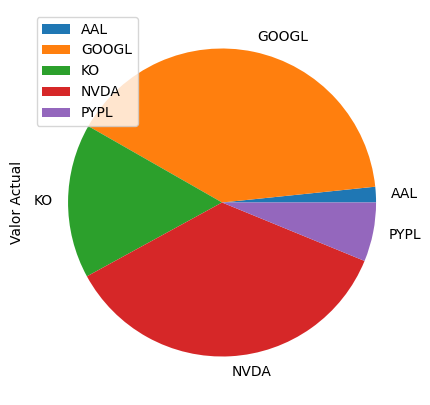

In [118]:
porta.posiciones.plot(kind = 'pie', y = 'Valor Actual', figsize = (5,5))

O se puede analizar el rendimiento obtenido en cada una de las inversiones realizadas.

<Axes: xlabel='ticker'>

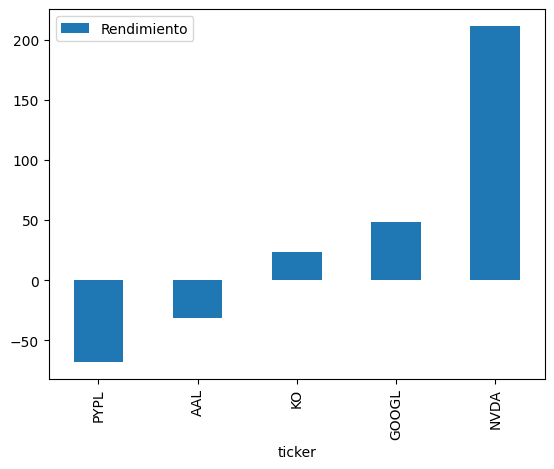

In [120]:
porta.posiciones.sort_values('Rendimiento').plot(kind = 'bar', y = 'Rendimiento')